# Sleep stages classification
___

This notebooks aims to explore the dataset [sleep-edf](https://physionet.org/content/sleep-edfx/1.0.0/) de _physionet_. 

We ultimatly want to discriminate sleep stages from recorded EEG data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import mne
from mne.datasets.sleep_physionet.age import fetch_data

## Data loading
____

Instead of downloading several times the dataset, we stock it once on our machine. We use the default path of mne, which is `~/mne_data/physionet-sleep-data`.

In [2]:
SUBJECTS = range(20)
NIGHT_RECORDINGS = [1, 2]

subject_files = fetch_data(subjects=SUBJECTS, recording=NIGHT_RECORDINGS);

Using default location ~/mne_data for PHYSIONET_SLEEP...


We also retrieve each patient information. We associate the same index as they are indexed within `subject_files`. Since we only have access to the first 20 patients data through MNE, we will discard patients information with an ID outside of that range.

When checking the `raw_data.info`, we can see that we have the property `raw_data.info["meas_date"]`, which represents the start date and time of the recording. We can then mark the moment of the signal where the lights were turned off.

In [3]:
df_subject_information = pd.read_csv("data/SC-subjects.csv", delimiter=';')

df_subject_information = df_subject_information.rename(columns={"sex (F=1)": "sex"}, errors="raise")
df_subject_information = df_subject_information[df_subject_information["subject"].isin(SUBJECTS)]

df_subject_information.head(5)


,subject,night,age,sex,LightsOff
0,0,1,33,1,0:38
1,0,2,33,1,21:57
2,1,1,33,1,22:44
3,1,2,33,1,22:15
4,2,1,26,1,22:50


## Channel exploration
___

We will explore the different channels for one subject's night. We will not look at the rectal temperature channel since we will not be able to get one ourself.


In [4]:
raw_data = mne.io.read_raw_edf(subject_files[13][0], preload=True, verbose=False)

NUMBER_CHANNELS = raw_data.info["nchan"]
LOWPASS_FILTER = raw_data.info["lowpass"]
SAMPLING_FREQ = raw_data.info["sfreq"]

print(raw_data)
print("The corresponding file has %i channels, has a low pass filter of %i Hz and a sampling rate of %i Hz." % (NUMBER_CHANNELS, LOWPASS_FILTER, SAMPLING_FREQ))
print("The channels are ", raw_data.info["ch_names"])
print(f"The recording is {raw_data.n_times/(3600 * SAMPLING_FREQ)} hours long.")

mapping = {'EEG Fpz-Cz': 'eeg',
           'EEG Pz-Oz': 'eeg',
           'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_data.set_channel_types(mapping)
raw_data.drop_channels('Temp rectal')
raw_data.set_annotations(mne.read_annotations(subject_files[13][1]), emit_warning=False)

<RawEDF  |  SC4062E0-PSG.edf, n_channels x n_times : 7 x 8490000 (84900.0 sec), ~453.4 MB, data loaded>
The corresponding file has 7 channels, has a low pass filter of 50 Hz and a sampling rate of 100 Hz.
The channels are  ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
The recording is 23.583333333333332 hours long.


<RawEDF  |  SC4062E0-PSG.edf, n_channels x n_times : 6 x 8490000 (84900.0 sec), ~388.7 MB, data loaded>

Because we cannot look at all the night's recording for all channels, since they have too many data points to be displayed and causes an error, we will look at the same subwindow of data for all channels.

In [5]:
DURATION = 30000.0
START_WINDOW = 24000

### EEG Channel
___

Electrode placement for this dataset was choosen along the midline axis. We have a **bipolar electrode montage**, which means that you have two electrodes per one channel, so you have a reference electrode for each channel.

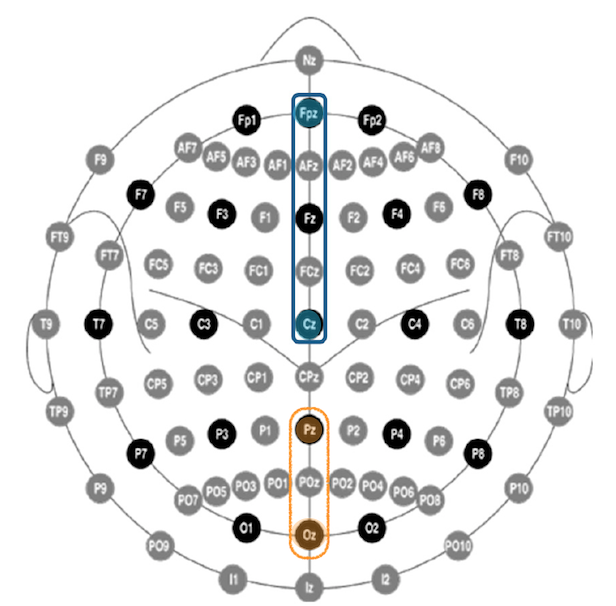

#### Fpz-Cz Channel
____

As its name states, it is an eeg signal with the electrode placed on the forehead and its reference placed on top of the head. Both are centered. They can be seen above in the blue rectangle.

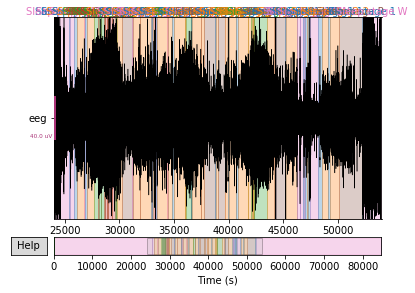

In [6]:
raw_data.copy().pick('EEG Fpz-Cz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Pz-Oz Channel
____

We can see the electrodes located at the back of the head follow the same pattern as with the other channel. The electrode montage for this channel is represented in orange in the figure above. 

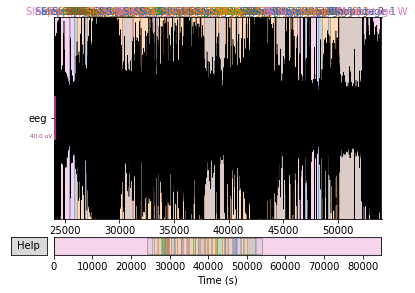

In [7]:
raw_data.copy().pick('EEG Pz-Oz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

We can then compare the PSD plot from both channels. We can see the general amplitude of the **EEG Fpz-Cz** channel is greater than the amplitude of the **EEG Pz-Oz** channel.

<ipython-input-8-5dbc023a3bd8>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);


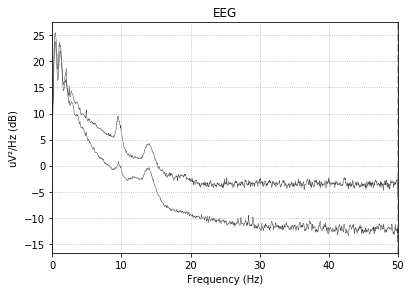

In [8]:
raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);


We keep both EEG channels because the goal of the classification is to use them as a way to distinguish sleep stages.

### EOG Channel
____

This channel is a horizontal EOG signal, with electrodes placed on both outer corners of the eyes, as you can see [here](https://www.researchgate.net/figure/Typical-EOG-electrode-placements-for-Horizontal-and-Vertical-channels_fig1_40452196).

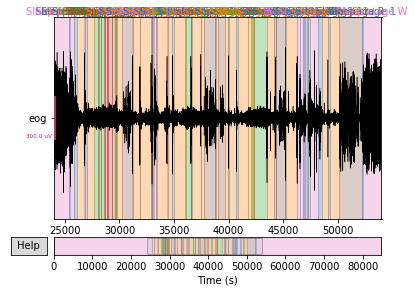

In [9]:
raw_data.copy().pick('EOG horizontal').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Eye movemnent artifact on EEG Channels
____

As it is described in this [tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/plot_10_preprocessing_overview.html#ocular-artifacts-eog), we can detect epochs that contain artefact of eye movement by looking at the EOG signal.

The result of the below operations center all epochs of the EEG channels around the eye movement artefact.

In [10]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw_data)


EOG channel index for this subject is: [2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1024 samples (10.240 sec)

Now detecting blinks and generating corresponding events
Found 27642 significant peaks
Number of EOG events detected : 27642
27642 matching events found
No baseline correction applied
Not setting metadata
Loading data for 27642 events and 101 original time points ...
1 bad epochs dropped


27641 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


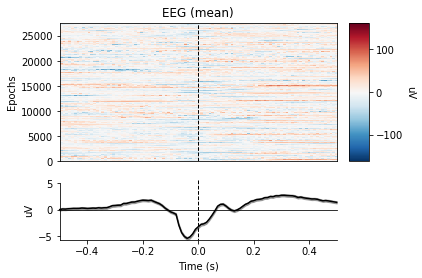

[<Figure size 432x288 with 3 Axes>]

In [11]:
eog_epochs.plot_image(combine='mean')


Even though the EOG signal is very useful to discriminate REM stage from the S1 stage [[source]](https://en.wikipedia.org/wiki/Polysomnography#Mechanism), we will not include it in our classifier, because we want to keep the montage simple for the end user.

### Chin EMG Channel
____

We finally also have a EMG channel to detect muscle movement near the mouth. We can see the electrodes are sort of placed as below:

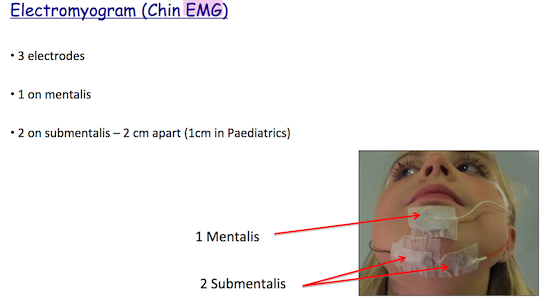

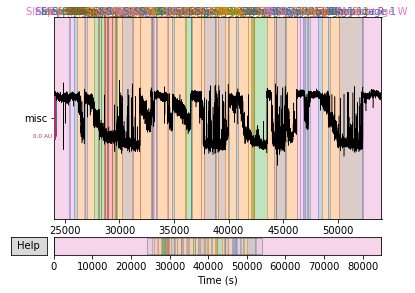

In [12]:
raw_data.copy().pick('EMG submental').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

For the same reason as with the EOG signal, which was to keep the montage simple, we will not use this signal for the classification.

### Event marker
____

It has a sampling rate of 1hz. This channel doesn't have a proper description, so we cannot interpret its meaning. We therefore ignore it.

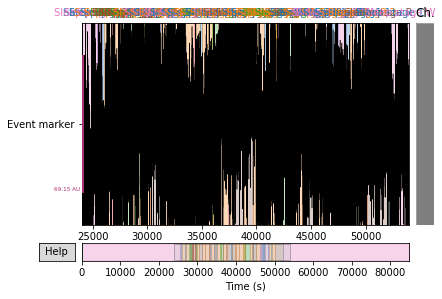

<RawEDF  |  SC4062E0-PSG.edf, n_channels x n_times : 5 x 8490000 (84900.0 sec), ~323.9 MB, data loaded>

In [13]:
raw_data.copy().pick('Event marker').plot(duration=DURATION, start=START_WINDOW);

raw_data.drop_channels(['Event marker'])


# Preprocessing
___

We're using an arbitrary 30 seconds window to create our epochs. We think it should be long enough to get an overview of what is the sleep stage. Also, we're merging the stage 3 and stage 4 into a stage 3/4, because it is the  American Academy of Sleep Medicine official standard since 2007 which is widely used in PSG and hypnograms in general.

## Data cleansing
___

We do not need to proceed to any particular data cleansing, since the technician who tagged our data, already did the job. We just need to ignore epochs without a sleep stage tag. These usually have the `?` marker, that correponds to an epoch that could not be classified. We also ignore epochs tagged with a `M`, which means the subject was moving while sleeping. We then just analyze epochs which were manually tagged as a valid sleep stage by the technician.

In [14]:
EPOCH_DURATION = 30. # in seconds

ANNOTATIONS_EVENT_ID = {
    'Sleep stage W': 0,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4,
    'Sleep stage R': 5,
    'Sleep stage ?': 6,
    'Movement time': 7
}

EVENT_ID = {
    'Sleep stage W': 0,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5,
    'Sleep stage ?': 6,
    'Movement time': 7
}

MAX_TIME = EPOCH_DURATION - 1. / SAMPLING_FREQ  # tmax in included

## Epoching
___
The following code create the epochs and store the files on the local computer. We should run it once.

In [15]:
# ## Comment the following code if you already saved the epochs into a .fif file.
from collections import Counter

all_subject_epochs = []

for i in range(10):
    print(f"Retrieving file no.{i}")
    # 1. get all epochs of one person
    raw_data = mne.io.read_raw_edf(subject_files[i][0], preload=True, verbose=False, exclude=["Temp rectal", "Event marker", "Resp oro-nasal", "EMG submental", "EOG horizontal"])

    # 2. add the sleep stage annotation to the raw data
    annotations = mne.read_annotations(subject_files[i][1])
    raw_data.set_annotations(annotations, emit_warning=False)
    
    # 3. only keep event ids present in the current file
    event_ids = EVENT_ID.copy()
    annotations_events = ANNOTATIONS_EVENT_ID.copy()
    if 'Movement time' not in np.unique(annotations.description):
        annotations_events.pop('Movement time', None)
        event_ids.pop('Movement time', None)

    # 4. transform into epochs
    events, _ = mne.events_from_annotations(raw_data, event_id=annotations_events, chunk_duration=EPOCH_DURATION, verbose=False)
    df = pd.DataFrame()
    df = df.append([df_subject_information.loc[[i]]] * len(events))
    try:
        epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_ids, tmin=0., tmax=MAX_TIME, baseline=None, verbose=False, metadata=df)
    except ValueError as e:
        # If no ? epochs are created, we need to ignore this class
        event_ids.pop('Sleep stage ?', None)
        epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_ids, tmin=0., tmax=MAX_TIME, baseline=None, verbose=False, metadata=df)
        
    #     epochs.equalize_event_counts(event_ids.keys())
    all_subject_epochs.append(epochs)

print("Concatenating all epochs together...")
epochs = mne.concatenate_epochs(all_subject_epochs)
epochs.save("data/data-epo.fif")

Retrieving file no.0
Retrieving file no.1
Retrieving file no.2
Retrieving file no.3
Retrieving file no.4
Retrieving file no.5
Retrieving file no.6
Retrieving file no.7
Retrieving file no.8
Retrieving file no.9
Concatenating all epochs together...
Overwriting existing file.


<ipython-input-15-f7498e90f184>:38: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  epochs.save("data/data-epo.fif")


Then, we can retrieve the epochs from the saved file.

In [16]:
epochs = mne.read_epochs("data/data-epo.fif")
epochs

Reading data/data-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   29990.00 ms
        0 CTF compensation matrices available
27606 matching events found
No baseline correction applied
Adding metadata with 5 columns
0 projection items activated


<EpochsFIF  |   27606 events (all good), 0 - 29.99 sec, baseline off, ~1.23 GB, data loaded, with metadata,
 'Movement time': 7
 'Sleep stage 1': 1005
 'Sleep stage 2': 4811
 'Sleep stage 3/4': 1267
 'Sleep stage ?': 2
 'Sleep stage R': 1902
 'Sleep stage W': 18612>

# Sleep stage visualization
___

We explore an example of an epoch of each sleep stage in the time domain in order to get an idea of our data.



In [17]:
EEG_CHANNELS = ['EEG Fpz-Cz','EEG Pz-Oz']

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


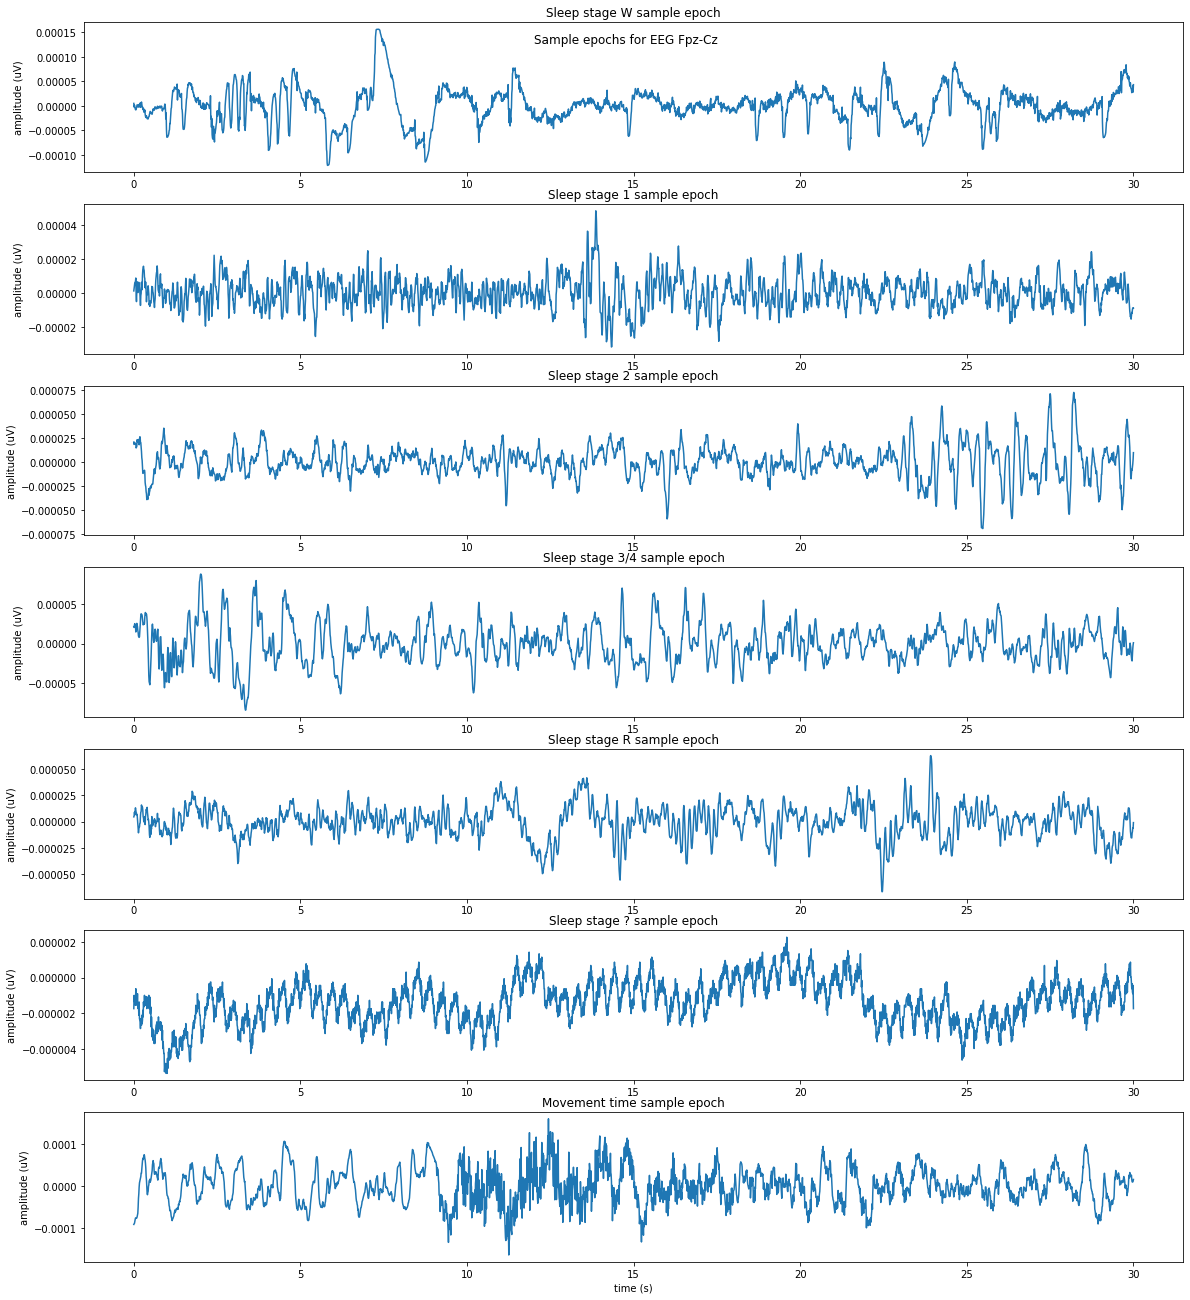

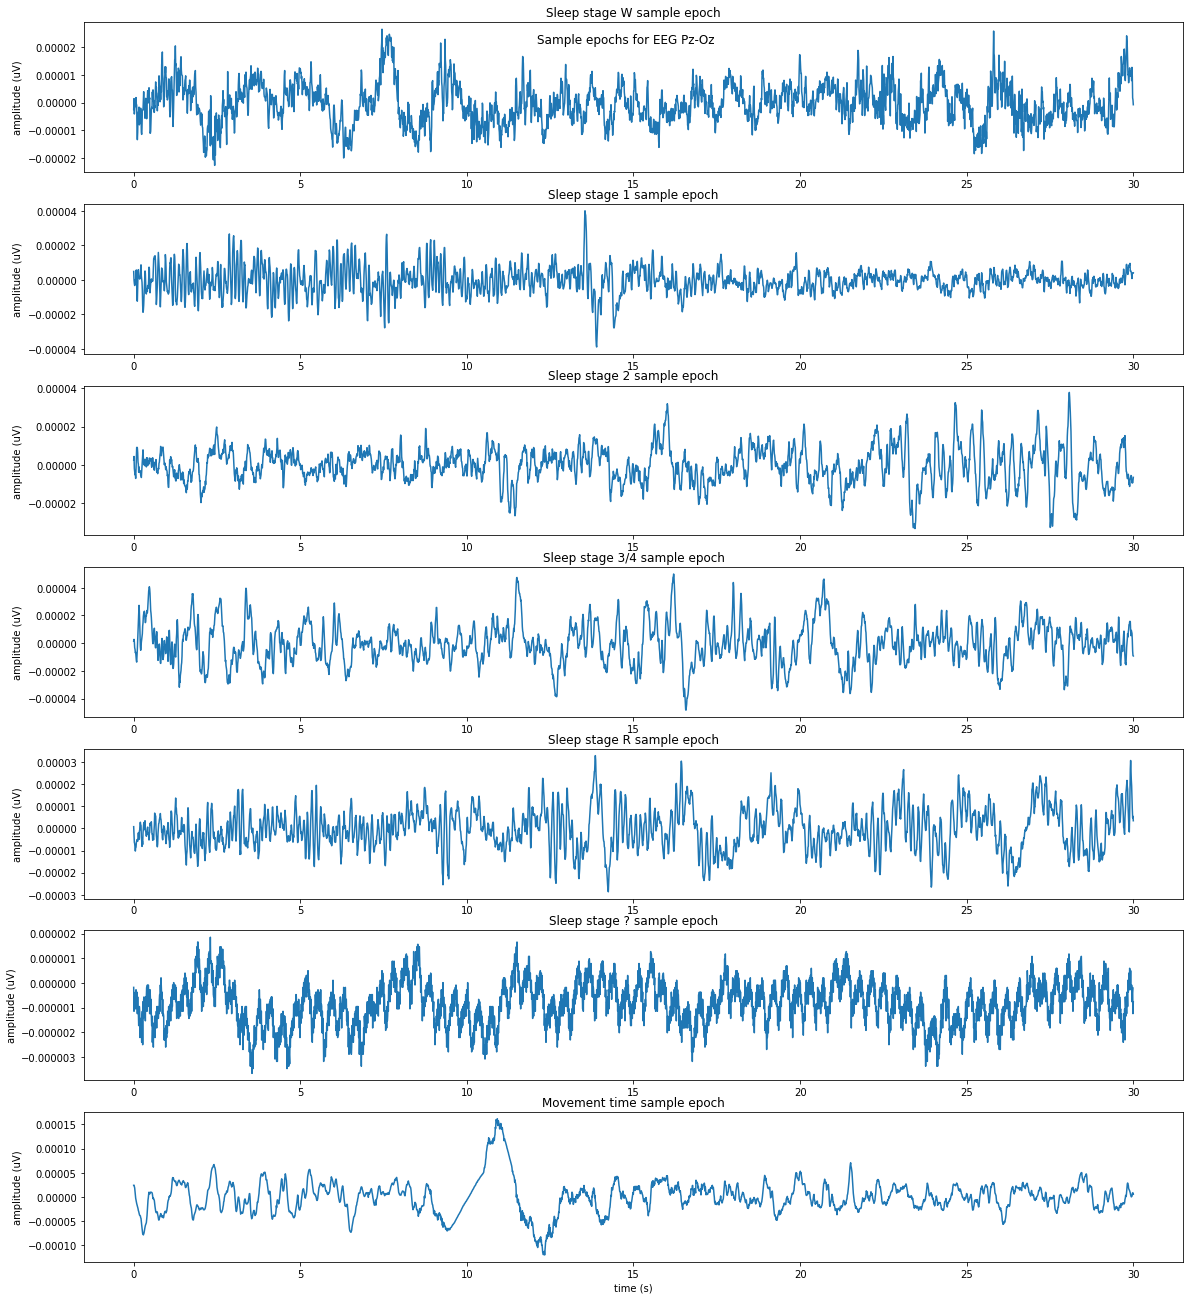

In [18]:
NROWS = 7

for j, channel in enumerate(EEG_CHANNELS):
    fig, ax = plt.subplots(nrows=NROWS, figsize=(16,18))
    fig.suptitle(f"Sample epochs for {channel}")
    plt.xlabel("time (s)")

    fig.tight_layout()
    for i, stage in enumerate(EVENT_ID.keys()):
        data = epochs[stage][0].get_data().squeeze()
        x = np.linspace(0.0, 30.0, len(data[j]))
        current_ax = ax[i]
        current_ax.plot(x, data[j])
        current_ax.set_title(f"{stage} sample epoch")
        current_ax.set_ylabel("amplitude (uV)")
    fig.show()


We can conclude that the `Sleep stage ?` and `Movement time` tags correspond to the data cleansing that was made by the technician. No need for fancy data cleansing!

We just drop both events from the epochs.

In [19]:
events = list(epochs.event_id.keys())
if 'Movement time' in events:
    events.remove('Movement time')
if 'Sleep stage ?' in events:
    events.remove('Sleep stage ?')

epochs = epochs[events]


## Analyzing PSD of epochs grouped by sleep stage score
____

We want to check if power band amplitudes change depending on the epoch's sleep stage class. We will then take all epochs with the same classification and then display their respective PSD.

In [20]:
epochs_df = epochs.to_data_frame(long_format=True, picks="eeg")
epochs_df.drop(columns='ch_type')

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,time,channel,observation
0,Sleep stage W,0,0.0,EEG Fpz-Cz,5.016850
1,Sleep stage W,0,0.0,EEG Pz-Oz,-2.467399
2,Sleep stage W,0,10.0,EEG Fpz-Cz,-2.578755
3,Sleep stage W,0,10.0,EEG Pz-Oz,1.467399
4,Sleep stage W,0,20.0,EEG Fpz-Cz,1.359707
...,...,...,...,...,...
165581995,Sleep stage W,27596,29970.0,EEG Pz-Oz,16.631257
165581996,Sleep stage W,27596,29980.0,EEG Fpz-Cz,17.358242
165581997,Sleep stage W,27596,29980.0,EEG Pz-Oz,1.295482
165581998,Sleep stage W,27596,29990.0,EEG Fpz-Cz,13.973627


In [21]:
epochs_df.head()

,condition,epoch,time,channel,observation,ch_type
0,Sleep stage W,0,0.0,EEG Fpz-Cz,5.016850,eeg
1,Sleep stage W,0,0.0,EEG Pz-Oz,-2.467399,eeg
2,Sleep stage W,0,10.0,EEG Fpz-Cz,-2.578755,eeg
3,Sleep stage W,0,10.0,EEG Pz-Oz,1.467399,eeg
4,Sleep stage W,0,20.0,EEG Fpz-Cz,1.359707,eeg


In [22]:
epoch_events = epochs_df[['epoch', 'condition']].drop_duplicates(keep="first").set_index('epoch')['condition'].to_numpy()
epoch_events

array(['Sleep stage W', 'Sleep stage W', 'Sleep stage W', ...,
       'Sleep stage W', 'Sleep stage W', 'Sleep stage W'], dtype=object)

We will use the [0.5, 30] Hz frequency band. **# TODO: Justify**

We're using the Welch's method in order to get a more accurate psd of our full 30 seconds epoch. Remember that EEG signals are not stationary and therefore, it is important to use Welch's method.

In [23]:
# psds will be of shape (n_epochs, n_channels, n_freqs) i.e. 8281 epochs x 2 channel x 75 freq

psds, freqs = mne.time_frequency.psd_welch(epochs, picks=EEG_CHANNELS, fmin=0.5, fmax=30.)

scaling = 1e6 # see here for default eeg scaling using for plotting (i.e. plot_psd): https://github.com/mne-tools/mne-python/blob/c437ed0bbcef3b6bf3a8beab2221ab5bff47722f/mne/defaults.py#L20 
psds *= scaling * scaling
np.log10(np.maximum(psds, np.finfo(float).tiny), out=psds)
psds *= 10

Effective window size : 2.560 (s)


In [24]:
len(freqs)

75

In [25]:

'''
ce qu'on voudrait serait un dataframe avec les colonnes suivantes
(pareil à epochs_df, sauf dans domain frequency avec psd):

- sleep-stage: event_id
- epoch: no de l'epoch
- frequency: fréquence issu de `freqs` (similaire à `time`de epochs_df)
- channel: EEG Fpz-Cz ou EEG Pz-Oz
- psd: valeur issue de `psds`

'''
psds_df_dict = { "stage": [],  "epoch": [], "frequency": [], "channel": [], "psd": [] }
NO_FREQS = len(freqs)

for no_epoch in range(len(psds)):
    current_sleep_stage = epoch_events[no_epoch]

    for no_channel in range(len(EEG_CHANNELS)):
        current_channel = EEG_CHANNELS[no_channel]
        
        psds_df_dict["stage"].extend([current_sleep_stage] * NO_FREQS)
        psds_df_dict["epoch"].extend([no_epoch] * NO_FREQS)
        psds_df_dict["channel"].extend([current_channel] * NO_FREQS)

        psds_df_dict["frequency"].extend(freqs)
        psds_df_dict["psd"].extend(psds[no_epoch][no_channel])


In [26]:
epoch_psds_df = pd.DataFrame(psds_df_dict)
epoch_psds_df

,stage,epoch,frequency,channel,psd
0,Sleep stage W,0,0.781250,EEG Fpz-Cz,26.649678
1,Sleep stage W,0,1.171875,EEG Fpz-Cz,23.550241
2,Sleep stage W,0,1.562500,EEG Fpz-Cz,22.896540
3,Sleep stage W,0,1.953125,EEG Fpz-Cz,20.748388
4,Sleep stage W,0,2.343750,EEG Fpz-Cz,21.039962
...,...,...,...,...,...
4139545,Sleep stage W,27596,28.125000,EEG Pz-Oz,-0.189811
4139546,Sleep stage W,27596,28.515625,EEG Pz-Oz,-2.044811
4139547,Sleep stage W,27596,28.906250,EEG Pz-Oz,1.873612
4139548,Sleep stage W,27596,29.296875,EEG Pz-Oz,2.563373


### Show mean psd
___

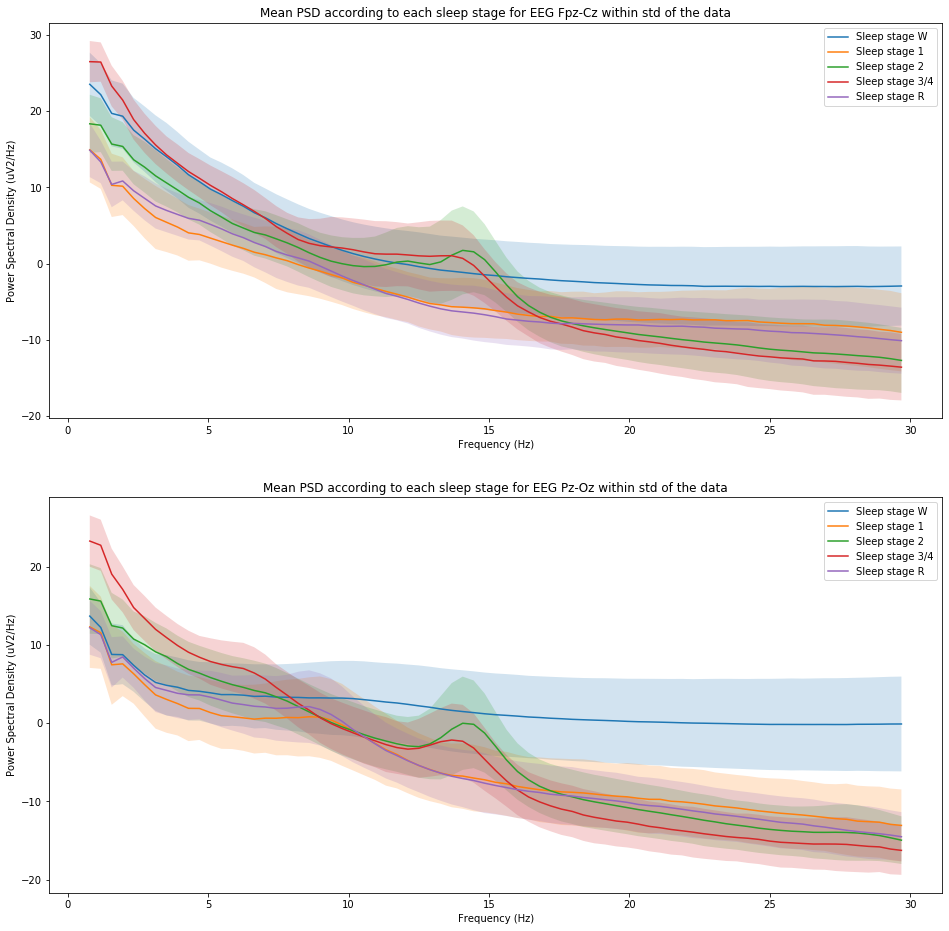

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

def plot_mean(x, y, name, ax, percentile=None):
    """ This function plot a channel line according"""
    calculation_df =  y.agg(['mean', 'std'])
    ax.plot(calculation_df.index, calculation_df['mean'], label=name)
    if percentile is 'std':
        ax.fill_between(x=x, y1=calculation_df['mean']+calculation_df['std'], y2=calculation_df['mean']-calculation_df['std'], alpha=0.2)
    elif percentile is 'range':
        lower_bound = y.quantile(0)
        upper_bound = y.quantile(1)
        ax.fill_between(x=x, y1=lower_bound, y2=upper_bound, alpha=0.2)
    elif percentile:
        if not 0 <= percentile <= 1:
            raise ValueError('percentile must be std or in the [0, 1] range')
        alpha = 1 - percentile
        lower_bound = y.quantile(alpha/2)
        upper_bound = y.quantile(1-(alpha/2))
        ax.fill_between(x=x, y1=lower_bound, y2=upper_bound, alpha=0.2)

def plot_stages_mean_psd(df, channel, ax, percentile=None):
    stages_psds = {stage: epoch_psds_df.query(f"channel == '{channel}' & stage == '{stage}'").groupby('frequency').psd for stage in epoch_psds_df.stage.unique()}
    freqs = epoch_psds_df.frequency.unique()
    for stage, psds in stages_psds.items():
        plot_mean(freqs, psds, stage, ax, percentile=percentile)
    ax.legend()
    title = f"Mean PSD according to each sleep stage for {channel}"
    title = title + f" within {percentile} of the data" if percentile else title
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (uV2/Hz)')

plot_stages_mean_psd(epoch_psds_df, 'EEG Fpz-Cz', ax[0], percentile='std')
plot_stages_mean_psd(epoch_psds_df, 'EEG Pz-Oz', ax[1], percentile='std')

### What we see
___

When looking at the standard deviation of the psds datapoints of the Pz-Oz channel, we can see that some are not overlapping a lot which is great news for future sleep stage classification. For example, at the beggining of the spectrum, sleep stage 3/4 can be clearly discriminated from the other stages. At the end of the spectrum (highest freqs), we can see that wake can be discriminated from sleep.
### With 95% most common values
___

We can use the range of the 95% most common values in order to have an idea of the range of the psd observations without the most obvious outliers.

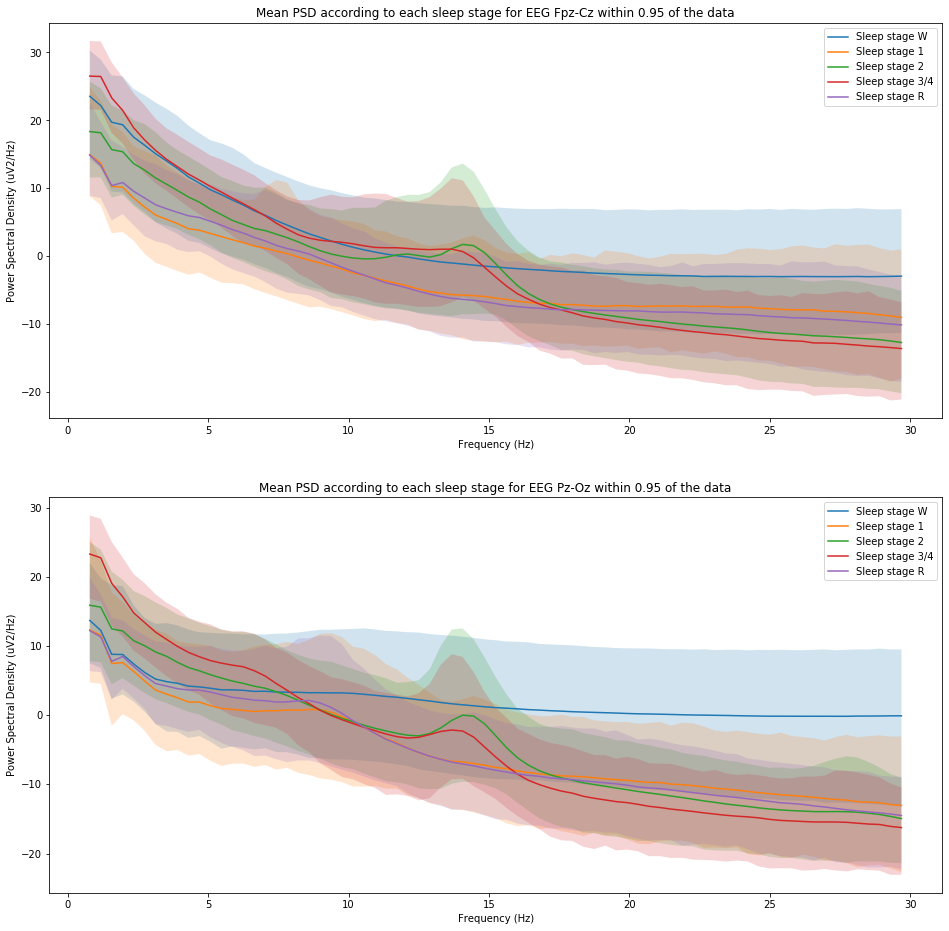

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

plot_stages_mean_psd(epoch_psds_df, 'EEG Fpz-Cz', ax[0], percentile=0.95)
plot_stages_mean_psd(epoch_psds_df, 'EEG Pz-Oz', ax[1], percentile=0.95)

### What we see
___
In this plot, we can see that deep sleep is linked to more power into slow waves and that wake stages are linked to more power at high frequencies.

Also, we suspect that the little hill between 11 and 16 Hz for sleep stage 2 is caused by spindles. However, we think we need a better detection method for the spindles, since it will not be easy to discriminate from the other stages.

Also, we can see that the range of the values for the psd of each stage is overlapping with each other wich seems to makes it harder to discriminate a stage with another.

It would be better to get an idea of the distribution of the psd, in order to know if we can discriminate these. To get an essence of the full distribution, we will calculate the relative power for each frequency band (delta, theta, alpha, beta, gamma) as often used in EEG experiments. Then, we'll plot a violin for each relative band power.

### Average band power
___

Average band power can simply obtained by integrating our psd for each frequency band. To numerically calculate our integral, we can calculate the sum of our psd data points for each frequency band.

First, we need to define our frequency bands

In [29]:
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30]
}

Then, we need to find calculate the power of each of these 5 frequency bands for every epochs we have.

In [88]:
def add_labels_on_plot(ax):
    ax.set_xticks(np.arange(1, len(stages) + 1))
    ax.set_xticklabels(stages)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Sleep stage')
    ax.set_ylabel('Power uV^2/Hz')

def plot_average_band_power_per_chan(df, ax, channel, stage, band, fmin, fmax):
    X = []
    for stage in stages:
        stages_psds = df.query(f"channel == '{channel}' & stage == '{stage}'")
        stages_psds = stages_psds[fmin < stages_psds.frequency]
        stages_psds = stages_psds[fmax >= stages_psds.frequency]
        x = stages_psds.groupby('epoch').psd.agg(['sum'])
        X.append(x.to_numpy().squeeze())

    ax.set_title(f"Average frequency power for the {band} band [{fmin}, {fmax}]")
    ax.violinplot(X, showmeans=True)
    add_labels_on_plot(ax)

def plot_average_band_power(df, channel):
    fig, ax = plt.subplots(nrows=len(FREQ_BANDS),figsize=(16, 16))
    stages = df.stage.unique()
    for i, (band, (fmin, fmax)) in enumerate(FREQ_BANDS.items()):
        plot_average_band_power_per_chan(df, ax[i], channel, stage, band, fmin, fmax)

    plt.tight_layout()
    fig.suptitle(f"Average frequency power for each power band for the {channel} channel", fontsize=18, fontweight='bold', y=1.05)

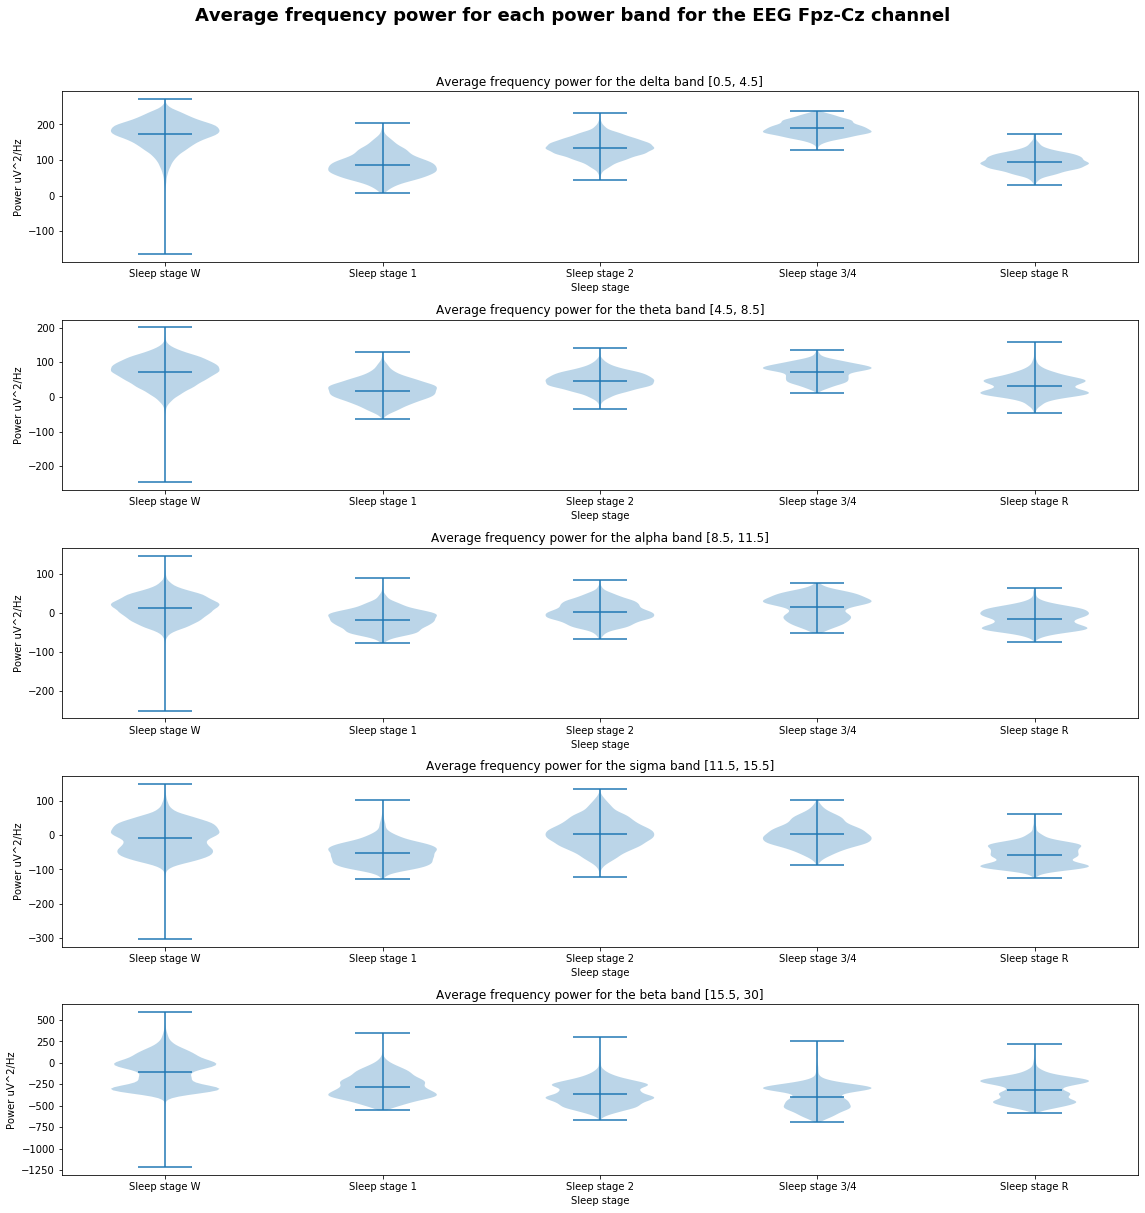

In [91]:
plot_average_band_power(epoch_psds_df, 'EEG Fpz-Cz')

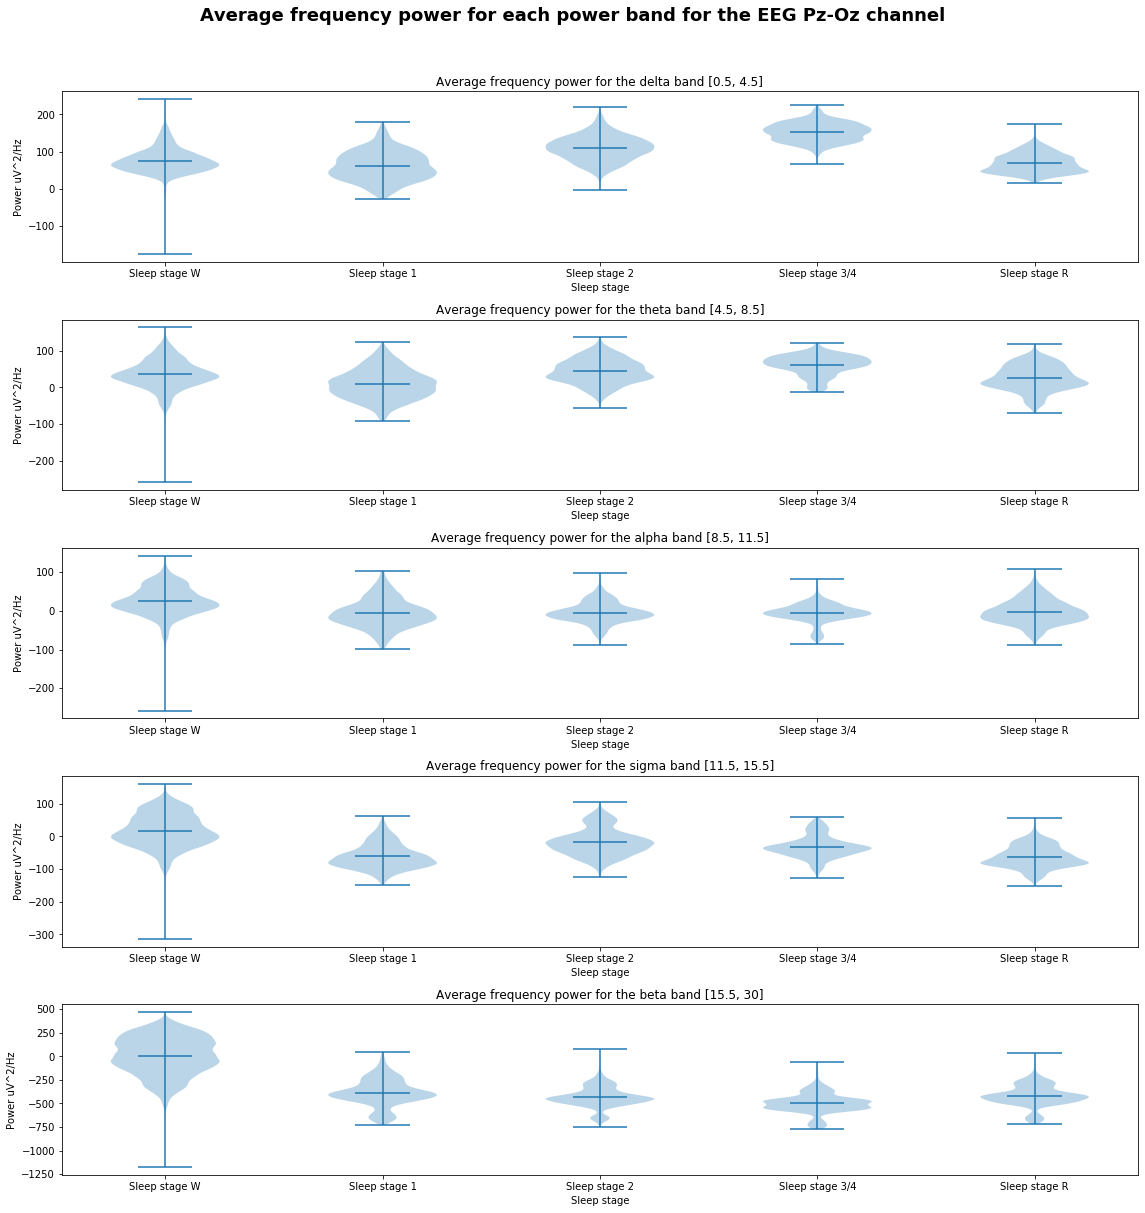

In [90]:
plot_average_band_power(epoch_psds_df, 'EEG Pz-Oz')

## Analyzing time domain features
___

Time domain features are easy to extract and can hold some information about the current sleep stage the subject is in. Moreover, manual sleep stage scoring is mostly realized only on the time domain EEG epochs, which indicates it is possible to select valuable time domain features.

### a. Standard statistics
___

The first features we will explore are the statiscical moments of each epoch. **Moments are a set of statistical parameters to measure a distribution**. In our case, we are looking at the distribution of the amplitudes (microVolt) accross all 30s epochs grouped by EEG channel and by sleep stage.

According to Koley [[1]](https://www.sciencedirect.com/science/article/pii/S0010482512001588?via%3Dihub#bib36), the statistical parameters can be used as features in order to classify sleep stages:

 > Among the various statistical properties of the EEG time series, the first- to fourth-order moments have already been used in preceding studies [28], [29], [32]. **The variance of EEG (M2) was found suitable for discriminating REM sleep from S2 and SWS [29].** These first- to fourth-order statistical parameters i.e., mean (M1), variance (M2), skewness (M3) and kurtosis (M4) were computed for the EEG epoch X(n) to quantify the central tendency, degree of dispersion, asymmetry and peakedness, respectively. These measurements were calculated using the formulas given in [36].
 
For each epoch and for each EEG channel, we want to look if we can discriminate the sleep stages with the following parameters: mean, variance, skewness and kurtosis.

***Note on how to read the following figures:***
The mean of the parameter is represented by the middle horizontal trait. The shape of the distribution of the parameter is represented by the blue area. Finally, the vertical bar represents the 100% confidence interval (range) of the calculated parameter. There is a calculation of the parameter for each epoch.

In [54]:
def plot_statistic_moment(measure_type, unit_label=""):
    fig, ax = plt.subplots(nrows=2,figsize=(16,10))
    stages = epochs_df.condition.unique().astype(str)
    print(f"The ordered violins are for: {stages}")

    for i, channel in enumerate(epochs_df['channel'].unique()):
        stats_epoch_df = epochs_df.query(f"channel == '{channel}'").groupby('epoch').agg({'condition': 'first', 'observation': measure_type})

        ax[i].violinplot([stats_epoch_df.query(f"condition == '{stage}'").observation.values for stage in stages], showmeans=True)
        ax[i].set_title(f"Distribution of the {measure_type} signal for {channel}")
        ax[i].set_ylabel(unit_label)
        ax[i].set_xticks(np.arange(1, len(stages) + 1))
        ax[i].set_xticklabels(stages)

    fig.show()

### I - Distribution of the mean of the signal
___

We plot the distribution of the mean values of all epochs. We can see the mean value of the mean time domain signal is generally the same within all epochs of the same observed channel (i.e. 0.4 uV for the Fpz-Cz channel and 0.25 uV for the Pz-Oz channel).

We can also see the distribution of the mean are generally the same within the same channel, whereas we have two normal distribution, closer in the first channel and more apart in the second channel. They are not quite aligned, which could be discriminating. It could be interesting to look at what causes this seperation in two normal distributions.

For those reasons, it is reasonable to assume the added information could be a bit significant.

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


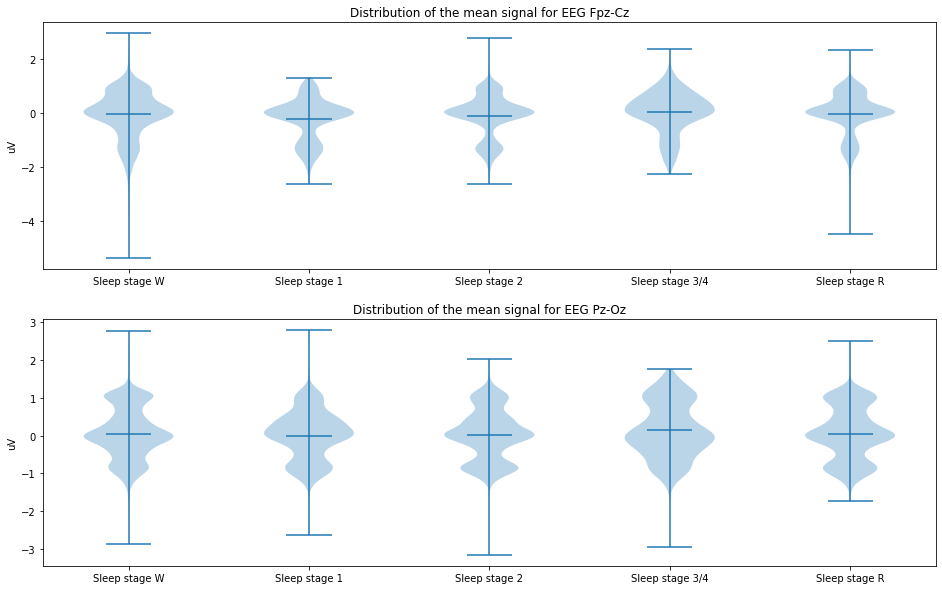

In [55]:
plot_statistic_moment(measure_type='mean', unit_label="uV")

### II - Distribution of the standard deviation of the signal
___

We plot the distribution of the standard deviation values of all epochs. We can see the mean value of the standard deviation of the time domain signal is quite different accross the different sleep stages, as we expected from the stated paper from Koley.

We can therefore expect the standard deviation of a time domain signal to discriminate the sleep stage classification.

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


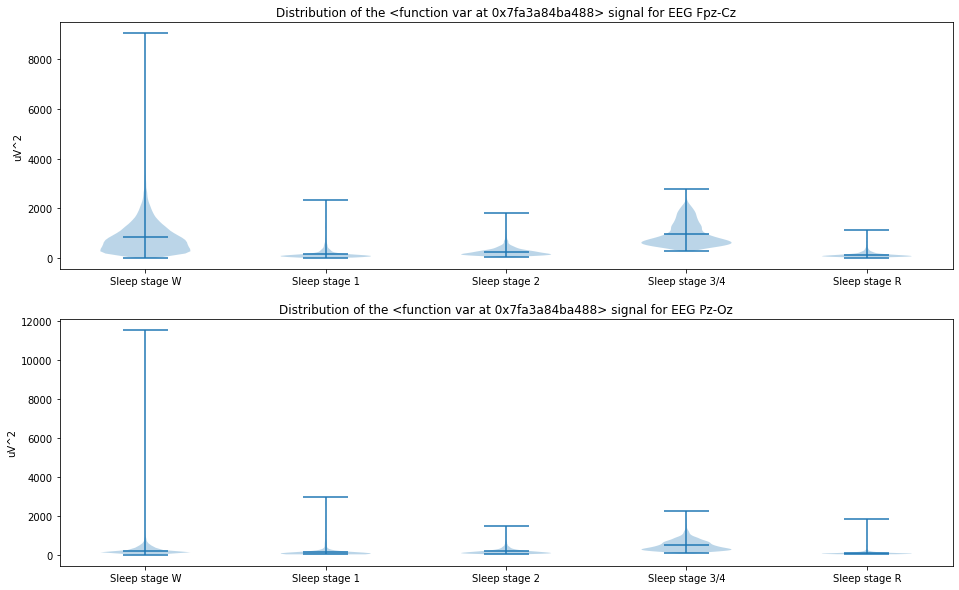

In [56]:
plot_statistic_moment(measure_type=np.var, unit_label="uV^2")

### III - Distribution of the skewness of the signal
___

We plot the distribution of the skewness value of all epochs. As with the distribution of the mean signal, whereas the mean and the distribution form is quite the same accross sleep stage scores, we assume the added information of this parameter is probably not significant.

Note: skewness does not have a unit [[source]](https://brownmath.com/stat/shape.htm).

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


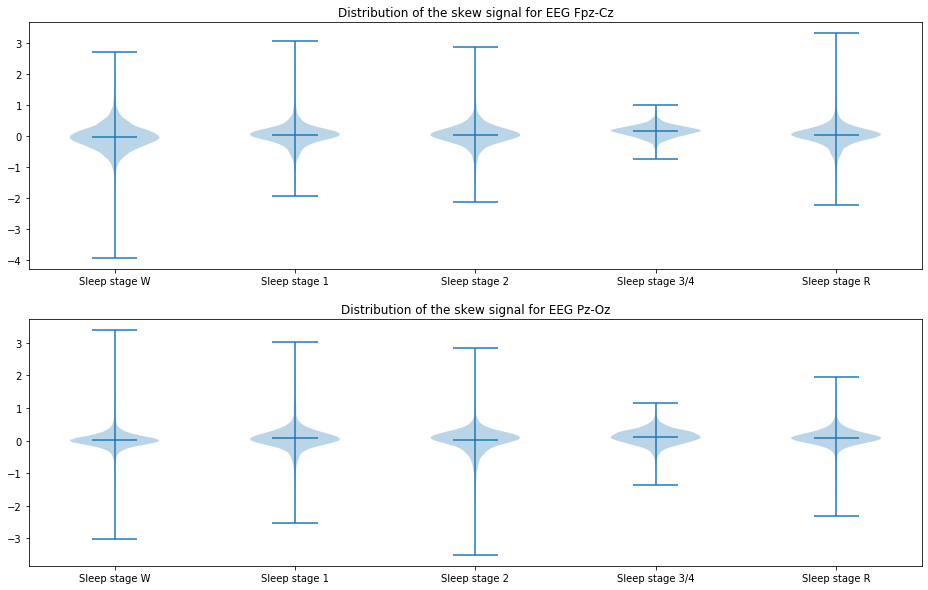

In [57]:
plot_statistic_moment(measure_type='skew')

### IV - Distribution of the kurtosis of the signal
___

We plot the distribution of the kurtosis value of all epochs. The same can be conclude as with the skewness, for the same observed reasons.

Note: kurtosis does not have a unit [[source]](https://brownmath.com/stat/shape.htm).

The ordered violins are for: ['Sleep stage W' 'Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3/4'
 'Sleep stage R']


/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


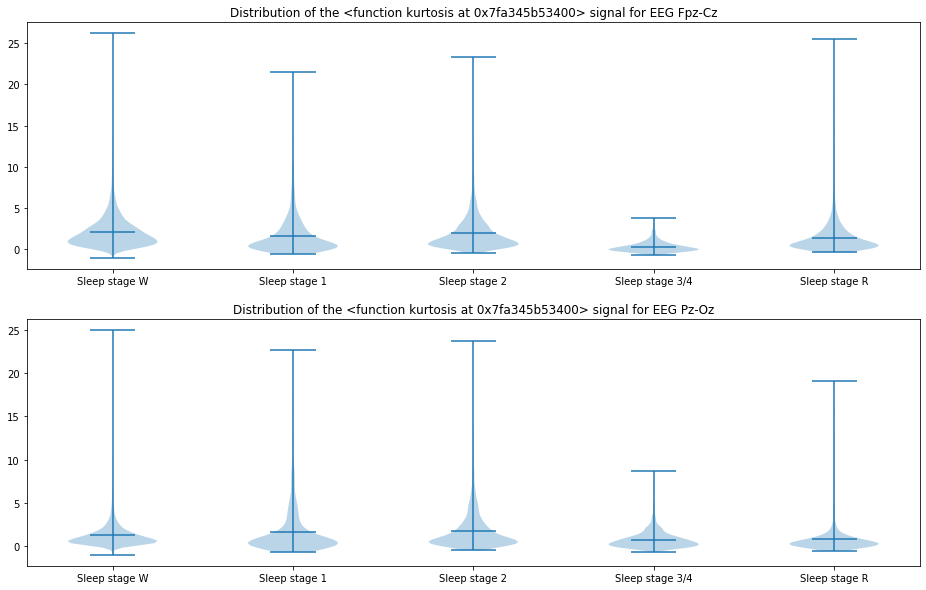

In [92]:
from scipy.stats import kurtosis

plot_statistic_moment(measure_type=kurtosis)

### Sleep spindles detection
___

[This blogpost]( https://raphaelvallat.com/spindles.html) shows a precise method to do spindles detection in sleep stage 2. As it is quoting:

>  According to the formal definition by the American Academy of Sleep Medicine (AASM), a sleep spindle is "a train of distinct 11–16 Hz waves, predominant over central EEG derivations and lasting more than 0.5 s".


In [ ]:
from mne.time_frequency import morlet
